In [54]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import copy

In [55]:
df = pd.read_csv('/content/drive/MyDrive/datasets/data-mining-ui/groceries.csv', header=None)

rows_len = df.shape[0]
columns_len = df.shape[1]
transactions = []

for row in range(rows_len):
  transaction = []
  for column in range(columns_len):
    cell = df.loc[row][column]
    if cell is not np.nan:
      transaction.append(cell)
  transactions.append(transaction)

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


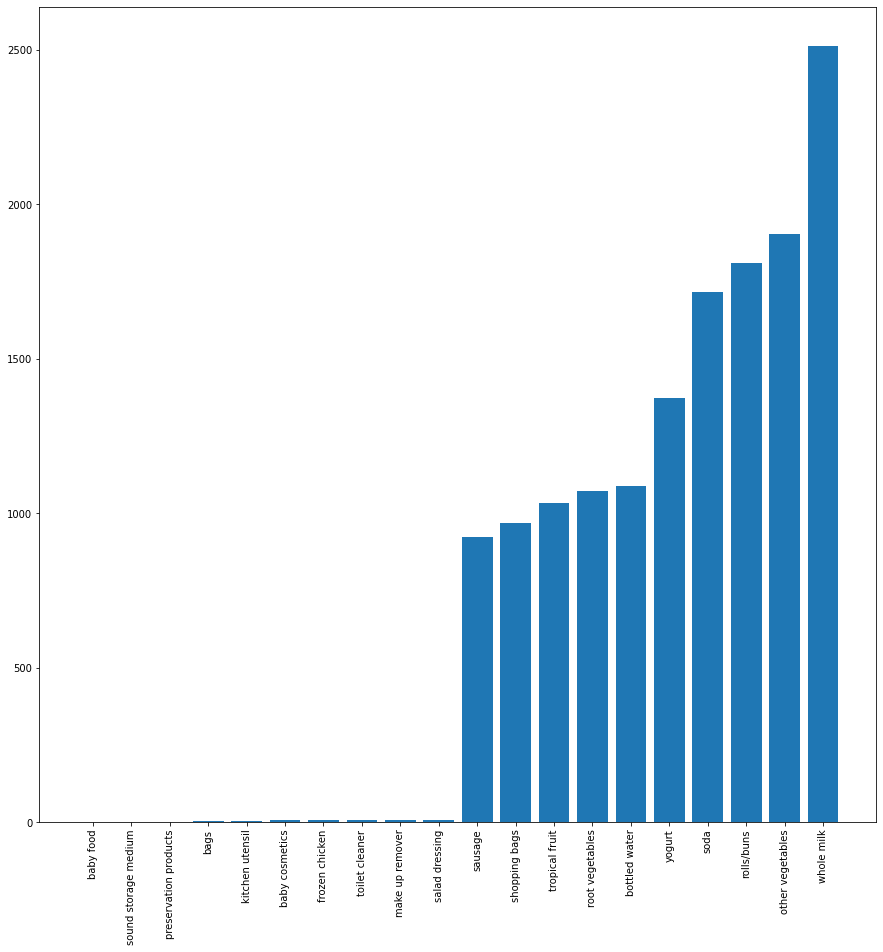

In [57]:
item_frequency = {}

for transaction in transactions:
  for item in transaction:
    if item in item_frequency:
      item_frequency[item] += 1
    else:
      item_frequency[item] = 1

sorted_item_frequency = sorted(item_frequency.items(), key=lambda kv:(kv[1], kv[0]))

max_x = []
max_y = []
min_x = []
min_y = []
for i in range(10):
  min_item = sorted_item_frequency[i][0]
  min_x.append(min_item)
  min_y.append(item_frequency[min_item])
  max_item = sorted_item_frequency[-(i+1)][0]
  max_x.append(max_item)
  max_y.append(item_frequency[max_item])

min_x.extend(reversed(max_x))
min_y.extend(reversed(max_y))
plt.figure(1, figsize=(15, 15))
plt.bar(min_x, min_y)
plt.xticks(rotation='vertical')
plt.show()

In [58]:
for t in transactions:
  for item in t:
    if '-.-' in item:
      print('invalid seperator!')

In [59]:
class Arules:
  def __init__(self):
    self.transactions = None
    self.frequent_item_sets = []
    self.items_frequency = {}

  def init_items_frequency(self):
    for transaction in self.transactions:
      for item in transaction:
        if item in self.items_frequency:
          self.items_frequency[item] += 1
        else:
          self.items_frequency[item] = 1

  def get_frequent_item_sets(self, transactions, min_support, min_confidence):
    self.transactions = transactions
    self.init_items_frequency()
    self.frequent_item_sets = []
    L1 = self.find_fequent_1_itemsets(transactions, min_support)
    self.frequent_item_sets.append(L1)

    k = 1
    while len(self.frequent_item_sets[k-1]) > 0:
      C_k = self.apriori_gen(self.frequent_item_sets[k-1])
      itemset_frequency = {}
      for t in transactions:
        C_t = self.subset(C_k, t)
        for c in C_t:
          index = self.create_index_from_list(c)
          if index in itemset_frequency:
            itemset_frequency[index] += 1
          else:
            itemset_frequency[index] = 1
      
      L_k = []
      for itemset in itemset_frequency:
        if itemset_frequency[itemset] >= min_support*len(transactions):
          L_k.append(itemset.split('-.-'))
      
      if len(L_k) > 0:
        self.frequent_item_sets.append(L_k)
        k += 1
      else:
        break

    return self.frequent_item_sets

  def create_index_from_list(self, l):
    s = '-.-'
    return s.join(l)

  def subset(self, candidates, transaction):
    C_t = []
    for c in candidates:
      flag = True
      for item in c:
        if item not in transaction:
          flag = False
          break    
      if flag:
        C_t.append(c)

    return C_t

  def apriori_gen(self, L_k_minus_one):
    C_k = []
    for l1 in L_k_minus_one: 
      for l2 in L_k_minus_one:
        if self.can_join(l1, l2):
          c = self.join_itemsets(l1, l2)
          if not self.has_infrequent_subset(c, L_k_minus_one):
            C_k.append(c)
    
    return C_k

  def join_itemsets(self, itemset1, itemset2):
    c = copy.deepcopy(itemset1)
    c.append(itemset2[-1])
    return c

  def can_join(self, itemset1, itemset2):
    if len(itemset1) != len(itemset2):
      return False

    itemset_size = len(itemset1)
    for k in range(itemset_size-1):
      if itemset1[k] != itemset2[k]:
        return False

    if itemset1[itemset_size-1] < itemset2[itemset_size-1]:
      return True
    else:
      return False

  def has_infrequent_subset(self, c, L_k_minus_one):
    k_minus_one_subsets_of_c = self.find_subsets(c, len(c) - 1)
    for subset in k_minus_one_subsets_of_c:
      if subset not in L_k_minus_one:
        return True

    return False

  def find_subsets(self, c, len_of_subsets):
    if len_of_subsets < 1:
      return []

    subsets = []
    for i in range(len(c)-(len_of_subsets-1)):
      for j in range(i+1, len(c)-(len_of_subsets-2)):
        first_item = c[i]
        remained_items = c[j: j+len_of_subsets-1]
        if len(remained_items) == len_of_subsets-1:
          subset = []
          subset.append(first_item)
          subset.extend(remained_items)
          if subset not in subsets:
            subsets.append(subset)

    return subsets

  def find_fequent_1_itemsets(self, transactions, min_support):
    frequent_1_itemsets = []
    for item in self.items_frequency:
      if self.items_frequency[item] >= min_support*len(transactions):
        frequent_1_itemsets.append([item])
    return frequent_1_itemsets
  
  def get_arules(self, transactions, min_support=None, min_confidence=None, min_lift=None, sort_by='lift'):
    frequent_item_sets = self.get_frequent_item_sets(transactions, min_support, min_confidence)
    rules = []

    for frequent_item_set_category in frequent_item_sets:
      if len(frequent_item_set_category[0]) == 1:
        continue
      for frequent_item_set in frequent_item_set_category:
        subsets = self.find_all_subsets(frequent_item_set, 1, len(frequent_item_set)-1)
        for subset in subsets:
          s = subset
          I_minus_s = list(set(frequent_item_set) - set(s))
          I_support = self.get_support(frequent_item_set, self.transactions)
          s_support = self.get_support(s, self.transactions)
          confidence = I_support / s_support
          if confidence >= min_confidence:
            rule = {}
            rule['s'] = s
            rule['I - s'] = I_minus_s
            rule['confidence'] = confidence
            I_minus_s_support = self.get_support(I_minus_s, self.transactions)
            lift = confidence / I_minus_s_support
            rule['lift'] = lift
            rules.append(rule)

    return sorted(rules, key=lambda key: key[sort_by]) 

  def get_support(self, itemset, transactions):
    support = 0
    for transaction in transactions:
      flag = True
      for item in itemset:
        if item not in transaction:
          flag = False
          break

      if flag:
        support += 1      

    return support / len(transactions)

  def find_all_subsets(self, itemset, from_size, to_size):
    subsets = []
    for i in range(from_size, to_size+1):
      subsets.extend(self.find_subsets(itemset, i))

    return subsets

In [60]:
arules = Arules()

frequent_itemsets = arules.get_frequent_item_sets(transactions, 0.005, 1)
for i, frequent_itemset in enumerate(frequent_itemsets, start=1):
  print('number of len', i, 'frequent itemsets is', len(frequent_itemset), 'and they are:', frequent_itemset)

rules = arules.get_arules(transactions, min_support=0.005, min_confidence=0.2)
for i, rule in enumerate(rules, start=1):
  print('rule number', i, 'is:', rule)



number of len 1 frequent itemsets is 120 and they are: [['citrus fruit'], ['semi-finished bread'], ['margarine'], ['tropical fruit'], ['yogurt'], ['coffee'], ['whole milk'], ['pip fruit'], ['cream cheese '], ['other vegetables'], ['condensed milk'], ['long life bakery product'], ['butter'], ['rice'], ['rolls/buns'], ['UHT-milk'], ['bottled beer'], ['liquor (appetizer)'], ['pot plants'], ['cereals'], ['white bread'], ['bottled water'], ['chocolate'], ['curd'], ['flour'], ['dishes'], ['beef'], ['frankfurter'], ['soda'], ['chicken'], ['sugar'], ['fruit/vegetable juice'], ['newspapers'], ['packaged fruit/vegetables'], ['specialty bar'], ['butter milk'], ['pastry'], ['processed cheese'], ['detergent'], ['root vegetables'], ['frozen dessert'], ['sweet spreads'], ['salty snack'], ['waffles'], ['candy'], ['canned beer'], ['sausage'], ['brown bread'], ['shopping bags'], ['beverages'], ['hamburger meat'], ['spices'], ['hygiene articles'], ['napkins'], ['pork'], ['berries'], ['whipped/sour cream'